In [ ]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

name = 'ru'

stay_points_path=f'result/stay_points/stay_points_{name}.csv'
# polygons_path='result/clusters/cl_tmp.feather'
polygons_path=f'result/clusters/cl_{name}.feather'
output_path=f'result/od/{name}/od_table.csv'

# 1. 读取停靠点数据
df = pd.read_csv(stay_points_path)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
df['timestamp_off'] = pd.to_datetime(df['timestamp_off'], format='mixed', errors='coerce')

# 2. 读取港口多边形数据
polygons_gdf = gpd.read_feather(polygons_path)

# 3. 将停靠点转为 GeoDataFrame（需要指定坐标系，假设为 WGS84）
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

# 4. 空间连接：将每个停靠点映射到其所在的多边形 label
#   predicate='within' 表示点在多边形内部
joined_gdf = gpd.sjoin(gdf, polygons_gdf, how='left', predicate='within')
joined_gdf = joined_gdf[joined_gdf['label'].notna()]
joined_gdf['label'] = joined_gdf['label'].astype(int)

# 为避免冲突，将 polygons_gdf 中的 'label' 列重命名
joined_gdf.rename(columns={'label': 'port_label'}, inplace=True)

# 5. 对结果按 mmsi、timestamp 排序，便于构造连续 OD
joined_gdf.sort_values(by=['mmsi', 'timestamp'], inplace=True)
joined_gdf.reset_index(drop=True, inplace=True)

# 6. 按 mmsi 分组，构造 OD
od_records = []
grouped = joined_gdf.groupby('mmsi', group_keys=True)

# 使用 tqdm 显示分组进度
for mmsi, group in tqdm(grouped, total=grouped.ngroups):
    group = group.sort_values('timestamp').reset_index(drop=True)
    
    # 逐对取相邻记录
    for i in range(len(group) - 1):
        O = group.loc[i]
        D = group.loc[i + 1]
        
        # 只记录 label 不同的 OD（即不同的港口多边形）
        if O['port_label'] != D['port_label'] and O['timestamp_off'] < D['timestamp']:
            od_records.append({
                'mmsi': mmsi,
                'O_label': O['port_label'],
                'O_latitude': O['latitude'],
                'O_longitude': O['longitude'],
                'O_timestamp': O['timestamp_off'],       # 使用 timestamp_off
                'D_label': D['port_label'],
                'D_latitude': D['latitude'],
                'D_longitude': D['longitude'],
                'D_timestamp': D['timestamp']            # 使用下一条 timestamp
            })

# 7. 生成 OD 表并保存
od_df = pd.DataFrame(od_records)
od_df.to_csv(output_path, index=False)
print(f"OD 表已保存到: {output_path}")

100%|██████████| 27965/27965 [01:43<00:00, 269.79it/s] 


OD 表已保存到: result/od/od_table.csv


In [8]:
import pandas as pd
import geopandas as gpd

name = 'ru'
date = pd.to_datetime('2022-02-24')
day = -30

# 1. 读取之前生成的 OD 表
od_df = pd.read_csv(f'result/od/{name}/od_table.csv')

od_df['O_timestamp'] = pd.to_datetime(od_df['O_timestamp'], errors='coerce')
od_df['D_timestamp'] = pd.to_datetime(od_df['D_timestamp'], errors='coerce')

if day > 0:
    start_date = date
    end_date = date + pd.Timedelta(days=day)
else:
    start_date = date + pd.Timedelta(days=day)
    end_date = date
od_df = (od_df[(od_df['O_timestamp'] >= start_date) & (od_df['D_timestamp'] < end_date)])

# 2. 聚合 OD 表：按 O_label 和 D_label 分组，统计每组的船舶数
agg_df = od_df.groupby(['O_label', 'D_label'], as_index=False).agg({'mmsi': 'count'})
agg_df.rename(columns={'mmsi': 'count'}, inplace=True)


# 3. 读取多边形数据，wp_tmp.feather，内含每个聚类的多边形和其他属性
polygons_gdf = gpd.read_feather(f'result/clusters/cl_{name}.feather')

# 4. 计算每个多边形的质心，并提取质心的经纬度
polygons_gdf = polygons_gdf.to_crs(epsg=3857)  # 投影到米为单位
polygons_gdf['centroid'] = polygons_gdf.geometry.centroid
polygons_gdf = polygons_gdf.to_crs(epsg=4326)  # 再投影回经纬度

polygons_gdf['centroid_lat'] = polygons_gdf.centroid.y
polygons_gdf['centroid_lon'] = polygons_gdf.centroid.x

# 5. 创建映射：以 label 为键，质心坐标为值
label_to_centroid = polygons_gdf.set_index('label')[['centroid_lat', 'centroid_lon']]

# 6. 将质心信息合并到聚合的 OD 表中
# 合并 O_label 的质心
agg_df = agg_df.merge(label_to_centroid, left_on='O_label', right_index=True, how='left')
agg_df.rename(columns={'centroid_lat': 'O_latitude', 'centroid_lon': 'O_longitude'}, inplace=True)

# 合并 D_label 的质心，使用不同的后缀
agg_df = agg_df.merge(label_to_centroid, left_on='D_label', right_index=True, how='left', suffixes=('', '_D'))
agg_df.rename(columns={'centroid_lat': 'D_latitude', 'centroid_lon': 'D_longitude'}, inplace=True)

# 7. 调整输出列顺序（不需要时间字段）
agg_df = agg_df[['O_label', 'O_latitude', 'O_longitude', 'D_label', 'D_latitude', 'D_longitude', 'count']]

# 8. 保存结果到 CSV 文件
output_csv = f'result/od/{name}/od_aggregated_{day}.csv'
agg_df.to_csv(output_csv, index=False)
print(f"OD 聚合结果已保存到: {output_csv}")

OD 聚合结果已保存到: result/od/ru/od_aggregated_-30.csv


/tmp/ipykernel_1735376/2166777401.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons_gdf['centroid_lat'] = polygons_gdf.centroid.y
/tmp/ipykernel_1735376/2166777401.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons_gdf['centroid_lon'] = polygons_gdf.centroid.x


In [ ]:
import pandas as pd
from tqdm import tqdm

# 设定日期和时间范围
date = pd.to_datetime('2022-02-24')
day_range = range(-30, 0)
suffix = 'before'
windows_size = 5

# 1. 读取之前生成的 OD 表
od_df = pd.read_csv(f'result/od/{name}/od_table.csv')

# 转换时间戳为 datetime 类型
od_df['O_timestamp'] = pd.to_datetime(od_df['O_timestamp'], errors='coerce')
od_df['D_timestamp'] = pd.to_datetime(od_df['D_timestamp'], errors='coerce')

# 2. 初始化一个空的列表用于存储转换后的动态图数据
dynamic_graph_records = []

# 3. 遍历 day_range 来处理每一天
for day in tqdm(day_range, desc="Processing days"):
    # 计算当前时间（以0点为准）
    current_time = date + pd.Timedelta(days=day)
    
    # 4. 按条件筛选：O_timestamp <= current_time <= D_timestamp
    valid_od_df = od_df[(od_df['O_timestamp'] <= current_time) & (od_df['D_timestamp'] >= current_time)]
    # valid_od_df = od_df[(od_df['O_timestamp'] <= current_time) & (od_df['O_timestamp'] + pd.Timedelta(days=windows_size) >= current_time)]
    
    # 5. 聚合每个 (source, target, time) 的记录，计算 weight
    for _, group in valid_od_df.groupby(['O_label', 'D_label']):
        # 每个 (source, target) 组合对应的时间和权重
        group_time = current_time
        weight = len(group)
        
        # 6. 记录到图数据中
        dynamic_graph_records.append({
            'source': group.iloc[0]['O_label'],
            'target': group.iloc[0]['D_label'],
            'weight': weight,
            'time': day - min(day_range)
        })

# 7. 将所有记录转换为 DataFrame，并根据 time, source, target 字段升序排序
dynamic_graph_df = pd.DataFrame(dynamic_graph_records)
dynamic_graph_df = dynamic_graph_df.sort_values(by=['time', 'source', 'target'])

# 8. 生成静态图（无时间维度）
# 获取静态图需要的时间范围（同 dynamic 使用的 date + day_range）
start_time = date + pd.Timedelta(days=min(day_range))
end_time = date + pd.Timedelta(days=max(day_range))

# 筛选落在 day_range 时间范围内的记录
static_od_df = od_df[
    (od_df['O_timestamp'] <= end_time) &
    (od_df['D_timestamp'] >= start_time)
]

# 生成静态图
static_graph_df = (
    static_od_df.groupby(['O_label', 'D_label'])
    .size()
    .reset_index(name='weight')
    .rename(columns={'O_label': 'source', 'D_label': 'target'})
)

# 9. 将结果保存到 CSV 文件
# 保存动态图到 CSV
dynamic_save_path = f'result/od/{name}/dynamic_graph_{suffix}.csv'
dynamic_graph_df.to_csv(dynamic_save_path, index=False)
print(f"动态图已保存到: {dynamic_save_path}")

# 保存静态图到 CSV
static_save_path = f'result/od/{name}/static_graph_{suffix}.csv'
static_graph_df.to_csv(static_save_path, index=False)
print(f"静态图已保存到: {static_save_path}")

Processing days: 100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


动态图已保存到: result/od/dynamic_graph_after.csv
静态图已保存到: result/od/static_graph_after.csv


In [ ]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# 计算结构信息的函数
def compute_node_metrics(path):
    df = pd.read_csv(path)
    df = df.groupby(['source', 'target'])['weight'].sum().reset_index()
    df['weight'] = 1.0

    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

    nodes = list(G.nodes())

    degree = dict(nx.degree_centrality(G))
    betweenness = dict(nx.betweenness_centrality(G))
    closeness = dict(nx.closeness_centrality(G))
    pagerank = dict(nx.pagerank(G))
    
    df_metrics = pd.DataFrame({
        'label': nodes,
        'degree': [degree.get(n, 0.0) for n in nodes],
        'betweenness': [betweenness.get(n, 0.0) for n in nodes],
        'closeness': [closeness.get(n, 0.0) for n in nodes],
        'pagerank': [pagerank.get(n, 0.0) for n in nodes]
    })

    df_metrics['degree_rank'] = df_metrics['degree'].rank(ascending=False)
    df_metrics['betweenness_rank'] = df_metrics['betweenness'].rank(ascending=False)
    df_metrics['closeness_rank'] = df_metrics['closeness'].rank(ascending=False)
    df_metrics['pagerank_rank'] = df_metrics['pagerank'].rank(ascending=False)
    
    return df_metrics

# 计算 before 和 after 的节点信息
before_metrics = compute_node_metrics(f"result/od/{name}/static_graph_before.csv")
after_metrics = compute_node_metrics(f"result/od/{name}/static_graph_after.csv")
# before_metrics = compute_node_metrics(f"result/od/{name}/dynamic_graph_before.csv")
# after_metrics = compute_node_metrics(f"result/od/{name}/dynamic_graph_after.csv")


# 重命名列方便区分
before_metrics = before_metrics.rename(columns={
    'degree': 'degree_before',
    'betweenness': 'betweenness_before',
    'closeness': 'closeness_before',
    'pagerank': 'pagerank_before',

    'degree_rank': 'degree_rank_before',
    'betweenness_rank': 'betweenness_rank_before',
    'closeness_rank': 'closeness_rank_before',
    'pagerank_rank': 'pagerank_rank_before',
})

after_metrics = after_metrics.rename(columns={
    'degree': 'degree_after',
    'betweenness': 'betweenness_after',
    'closeness': 'closeness_after',
    'pagerank': 'pagerank_after',

    'degree_rank': 'degree_rank_after',
    'betweenness_rank': 'betweenness_rank_after',
    'closeness_rank': 'closeness_rank_after',
    'pagerank_rank': 'pagerank_rank_after',
})

# 合并 before 和 after
ranks = pd.merge(before_metrics, after_metrics, on='label', how='outer')
ranks['degree_rank_grow'] = ranks['degree_rank_before'] - ranks['degree_rank_after']
ranks['betweenness_rank_grow'] = ranks['betweenness_rank_before'] - ranks['betweenness_rank_after']
ranks['closeness_rank_grow'] = ranks['closeness_rank_before'] - ranks['closeness_rank_after']
ranks['pagerank_rank_grow'] = ranks['pagerank_rank_before'] - ranks['pagerank_rank_after']

# 加载聚类信息并合并
clusters = pd.read_csv(f"result/clusters/cl_{name}.csv")
clusters['label'] = clusters['label'].astype(int)
ranks['label'] = ranks['label'].astype(int)
result = pd.merge(clusters, ranks, on='label', how='left')

# 统计 ship_cnts 排名（假设 ship_cnts 列已存在）
if 'ship_cnts' in result.columns:
    result['ship_rank'] = result['ship_cnts'].rank(ascending=False, method='min').astype(int)

# 保存最终结果
result.to_csv(f"result/od/{name}/od_feature.csv", index=False)

print(f"特征文件已保存至 result/od/{name}/od_feature.csv")


特征文件已保存至 result/od/od_feature.csv


[Degree Centrality]
  R² score: 0.8568360555327815
[Betweenness Centrality]
  R² score: 0.7664872278267783
[Closeness Centrality]
  R² score: 0.7093818668494241
[PageRank]
  R² score: 0.6666025399208899


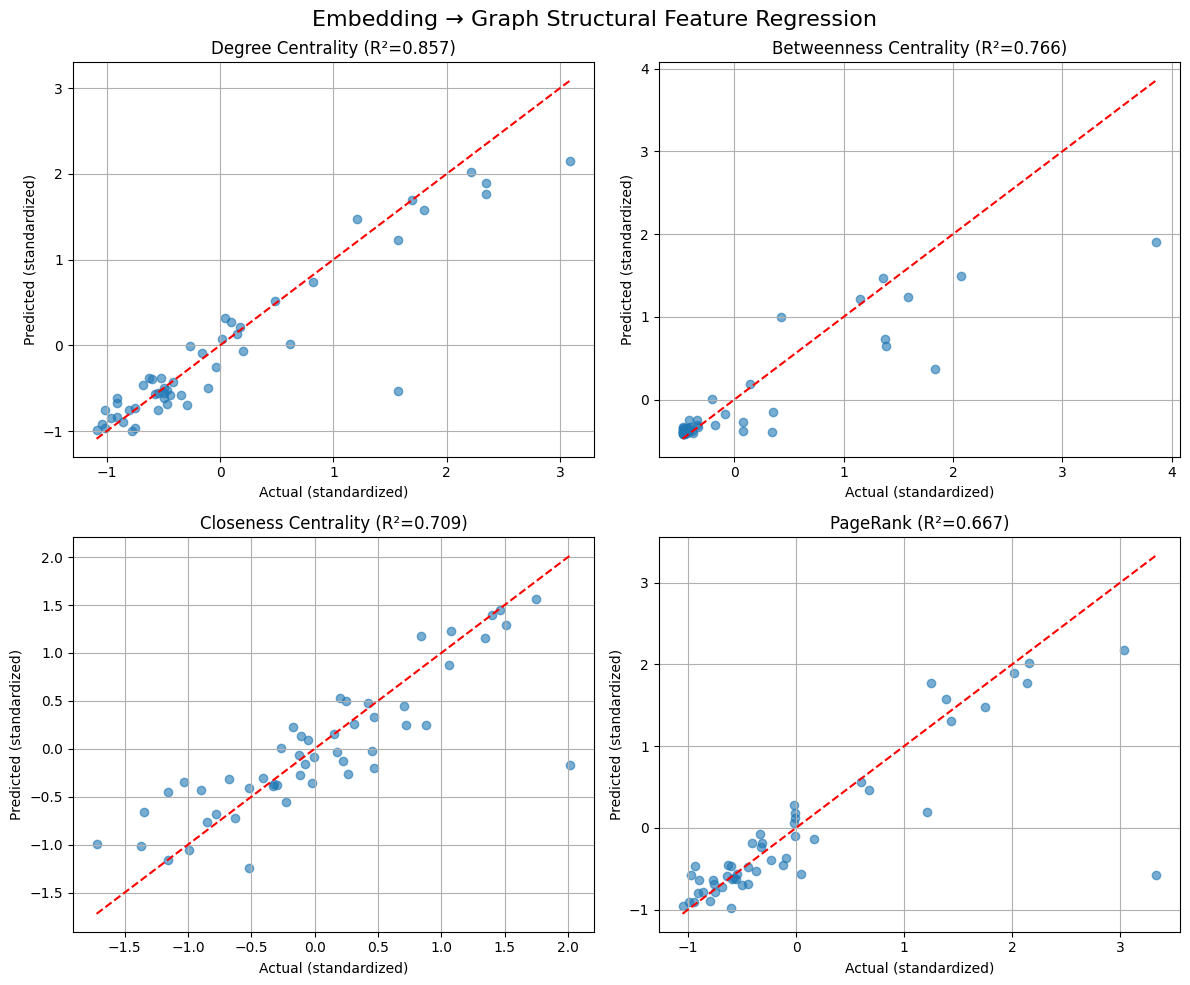

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

name = 'ru'
pred_columns = ['degree_before', 'betweenness_before', 'closeness_before', 'pagerank_before']

# 加载嵌入
emb_df = pd.read_csv(f"result/graph_embedding/{name}/nodeembs_before_lstmB.csv", header=None)
emb_df = emb_df.rename(columns={0: 'label'})
features = emb_df.drop(columns='label').values
labels = emb_df['label'].astype(int).values

# 加载结构特征
rank_df = pd.read_csv(f"result/od/{name}/od_feature.csv")
rank_df['label'] = rank_df['label'].astype(int)

# 合并 & 排序
merged = pd.DataFrame({'label': labels})
merged = merged.merge(rank_df[['label'] + pred_columns], on='label', how='left')

# 创建子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, col in enumerate(pred_columns):
    valid_mask = ~merged[col].isna().values
    X = features[valid_mask]
    y = merged[col].values[valid_mask]

    # 归一化
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

    model = SVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 评估
    r2 = r2_score(y_test, y_pred)
    # mae = mean_absolute_error(y_test, y_pred)
    # mse = mean_squared_error(y_test, y_pred)

    col = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'PageRank'][i]
    print(f"[{col}]")
    print("  R² score:", r2)
    # print("  MAE:", mae)
    # print("  MSE:", mse)

    # 可视化
    ax = axs[i]
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_xlabel("Actual (standardized)")
    ax.set_ylabel("Predicted (standardized)")
    ax.set_title(f"{col} (R²={r2:.3f})")
    ax.grid(True)

plt.suptitle("Embedding → Graph Structural Feature Regression", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely import wkt  # 用于解析 WKT 格式
from math import radians, sin, cos, sqrt, atan2

name = 'ru'

# 计算大圆距离
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # 地球半径（单位：公里）
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Gini系数计算
def gini_coefficient(degrees):
    sorted_degrees = np.sort(degrees)
    n = len(degrees)
    cum_degrees = np.cumsum(sorted_degrees)
    cum_prop = cum_degrees / cum_degrees[-1] if cum_degrees[-1] != 0 else np.zeros_like(cum_degrees)
    lorenz_curve = np.insert(cum_prop, 0, 0)
    B = np.trapz(lorenz_curve, dx=1/n)
    return 1 - 2 * B

# 读取聚类中心（取体心）
def load_cluster_centroids(path):
    gdf = gpd.read_feather(path)
    gdf = gdf.to_crs(epsg=3857)  # 投影到米为单位
    gdf['centroid'] = gdf.geometry.centroid
    gdf = gdf.to_crs(epsg=4326)  # 再投影回经纬度
    centroids = {row['label']: (row['centroid'].y, row['centroid'].x) for _, row in gdf.iterrows()}
    return centroids

# 主函数：计算动态图的指标
def compute_dynamic_graph_metrics(path, centroid_dict):
    df = pd.read_csv(path)
    df = df.groupby(['source', 'target']).size().reset_index(name='weight')

    # 使用大圆距离替代权重
    new_weights = []
    for _, row in df.iterrows():
        src = centroid_dict.get(row['source'])
        tgt = centroid_dict.get(row['target'])
        if src and tgt:
            distance = haversine(src[1], src[0], tgt[1], tgt[0])
            new_weights.append(distance)
        else:
            new_weights.append(1.0)  # fallback weight
    df['weight'] = new_weights

    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    # NV：Network Connectivity
    NV = n * (n - 1)

    # NS：Network Size
    NS = n + m

    # ND：Network Density（平均距离反比）
    distances = [d['weight'] for u, v, d in G.edges(data=True)]
    dis_avg = np.mean(distances)
    ND = n / dis_avg

    # NC：Network Centrality（平均度中心性）
    degree_centralities = [deg for node, deg in G.degree()]
    NC = np.mean(degree_centralities)

    # Gini：节点度的Gini系数
    Gini = gini_coefficient(degree_centralities)

    # Resilience R
    R = (NV * NS) / (ND * NC * Gini)

    return {
        "Network Connectivity": NV,
        "Network Size": NS,
        "Network Density": ND,
        "Network Centrality": NC,
        "Gini Coefficient": Gini,
        "Network Resilience": R
    }

# 加载聚类体心坐标
centroids = load_cluster_centroids(f"result/clusters/cl_{name}.feather")

# 读取前后文件并计算
metrics_before = compute_dynamic_graph_metrics(f"result/od/{name}/static_graph_before.csv", centroids)
metrics_after = compute_dynamic_graph_metrics(f"result/od/{name}/static_graph_after.csv", centroids)

# 输出为分析表格
result_df = pd.DataFrame([metrics_before, metrics_after], index=["Before", "After"])
print(result_df)


        Network Connectivity  Network Size  Network Density  \
Before                 64770          5769         0.025508   
After                  65792          5245         0.025743   

        Network Centrality  Gini Coefficient  Network Resilience  
Before           43.247059          0.466155        7.266344e+08  
After            38.817121          0.470145        7.345332e+08  


/tmp/ipykernel_45184/1398323107.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(lorenz_curve, dx=1/n)
/tmp/ipykernel_45184/1398323107.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(lorenz_curve, dx=1/n)
